In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(1563, 20)
(1563, 3)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.24316425621509552, 0.12834718823432922,
       -0.3836668133735657, 0.23878607153892517, -0.131938174366951,
       -0.36480507254600525, -0.2585662603378296, 0.12253835797309875,
       -0.3686639368534088, -0.25985878705978394, -0.12464121729135513,
       -0.3830992579460144, 0.0, 0.0, 0.0, True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [9]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [11]:
idx_fl_rr_swinging.shape

(780,)

In [12]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.24316425621509552, 0.12834718823432922,
       -0.3836668133735657, 0.23878607153892517, -0.131938174366951,
       -0.36480507254600525, -0.2585662603378296, 0.12253835797309875,
       -0.3686639368534088, -0.25985878705978394, -0.12464121729135513,
       -0.3830992579460144, 0.0, 0.0, 0.0, True, False], dtype=object)

In [13]:
Y_motion_CoM_FL_RR[0, :]

array([0.0002006561349540137, -0.005639766167924484,
       0.0009616162325033761], dtype=object)

## Predict CoM -> x

### Linear Regression

In [14]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, -5:-2], # Previous motion command
               X_motion_CoM_FL_RR[:, :3], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.97088092855111
RMSE:  0.01109044031758733
The lowest error is:  1.8373831184859135e-06
The highest error is:  0.052535705843574115
The avg. error is:  0.0074003891886364045


In [15]:
model_fl_com_x.coef_

array([[ 4.52958116e-02,  5.55111512e-17, -5.55111512e-17,
         1.17559859e-01, -2.49800181e-16,  2.77555756e-17,
        -3.76058725e-01,  3.65030691e-02,  5.07825311e-01,
         9.24184008e-01, -3.14873512e-01, -5.99854750e-01,
        -4.17385907e-01, -8.97012315e-01]])

In [16]:
model_fl_com_x.intercept_

array([-0.14768165])

In [17]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.00777596]])

Text(0, 0.5, 'Predictions')

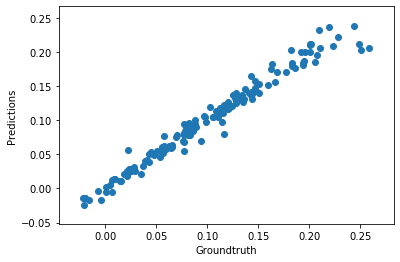

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [19]:
#%store model_fl_com_x

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [22]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, -5:-2], # Previous motion command
               X_motion_CoM_FL_RR[:, :3], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.05779450635731531
RMSE:  0.003563684850231647
The lowest error is:  8.34241854469342e-06
The highest error is:  0.012351069707988403
The avg. error is:  0.002693950284774535


In [23]:
model_fl_com_y.coef_

array([[-4.09720989e-03, -4.68375339e-17, -6.96057795e-17,
        -2.65430680e-04,  0.00000000e+00, -1.11022302e-16,
        -9.78155604e-02, -6.39772941e-01,  5.51243049e-02,
         2.10072324e-01, -5.94327029e-02,  2.27566328e-01,
         4.61211123e-02, -2.35416061e-01]])

In [24]:
model_fl_com_y.intercept_

array([0.05630789])

Text(0, 0.5, 'Predictions')

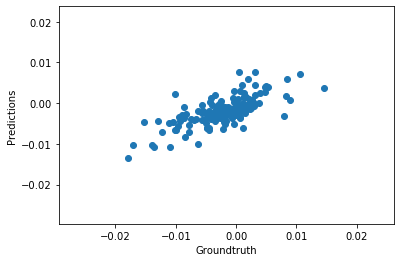

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [26]:
#%store model_fl_com_y

In [27]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [28]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [29]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, -5:-2], # Previous motion command
               X_motion_CoM_FL_RR[:, :3], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.0775385571189853
RMSE:  0.0036129109678127774
The lowest error is:  2.8655286851815565e-05
The highest error is:  0.03534852539892337
The avg. error is:  0.0019667119824462297


In [30]:
model_fl_com_theta.coef_

array([[-2.06496524e-03,  1.73472348e-18, -4.33680869e-18,
        -5.77681429e-03, -1.73472348e-17, -2.77555756e-17,
        -7.33784330e-03, -1.05762075e-01,  3.86233177e-02,
         7.52059702e-02, -1.12792307e-02, -2.50944653e-02,
         4.56671218e-02,  1.07287847e-01]])

In [31]:
model_fl_com_theta.intercept_

array([0.04288928])

Text(0, 0.5, 'Predictions')

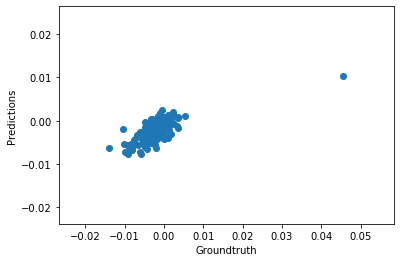

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")